In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import zipfile
import os
import pandas as pd
import gc

# Function to extract ZIP files
def extract_zip(zip_file_path, extract_folder):
    os.makedirs(extract_folder, exist_ok=True)
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_folder)

# Extract the training and test data
extract_zip('/content/drive/MyDrive/Copy of GUIDE_Train.csv.zip', '/content/extracted_folder')
extract_zip('/content/drive/MyDrive/Copy of GUIDE_Test.csv.zip', '/content/extracted_folder')

# Define the features to keep and the target column
target_column = 'IncidentGrade'
columns_to_keep = [
    'AlertTitle', 'Category', 'MitreTechniques', 'ActionGrouped', 'ActionGranular',
    'EntityType', 'EvidenceRole', 'ResourceType', 'Roles', 'OSFamily', 'OSVersion',
    'LastVerdict', 'CountryCode', 'State', 'City', 'ThreatFamily', 'DetectorId',
    'DeviceId', 'FileName', 'FolderPath', 'AntispamDirection', 'IpAddress', 'Sha256', 'Url'
]

# Function to downcast numerical columns to save memory
def downcast_dataframe(df):
    for col in df.select_dtypes(include=['float64']).columns:
        df[col] = pd.to_numeric(df[col], downcast='float')
    for col in df.select_dtypes(include=['int64']).columns:
        df[col] = pd.to_numeric(df[col], downcast='integer')
    return df

# Function to remove columns with more than 80% null values
def drop_high_null_columns(df, threshold=0.8):
    null_percentage = df.isnull().mean()
    cols_to_drop = null_percentage[null_percentage > threshold].index
    df = df.drop(columns=cols_to_drop)
    return df

# Function to process CSV in chunks
def process_csv_in_chunks(csv_file_path, features, target_column, chunk_size=100000):
    chunk_list = []

    for chunk in pd.read_csv(csv_file_path, chunksize=chunk_size, low_memory=False):
        # Select relevant columns
        chunk = chunk[[target_column] + features]

        # Downcast the data types to reduce memory usage
        chunk = downcast_dataframe(chunk)

        # Drop columns with more than 80% null values
        chunk = drop_high_null_columns(chunk, threshold=0.8)

        # Drop duplicates
        chunk = chunk.drop_duplicates()

        # Store processed chunk
        chunk_list.append(chunk)

        # Clear memory
        del chunk
        gc.collect()

    # Concatenate all processed chunks into a single DataFrame
    return pd.concat(chunk_list, ignore_index=True)

# Process Train DataFrame
train_csv_path = '/content/extracted_folder/GUIDE_Train.csv'
train_df = process_csv_in_chunks(train_csv_path, columns_to_keep, target_column)

# Process Test DataFrame
test_csv_path = '/content/extracted_folder/GUIDE_Test.csv'
test_df = process_csv_in_chunks(test_csv_path, columns_to_keep, target_column)

# Display first 5 rows of each DataFrame
print("Train DataFrame:")
print(train_df.head(5))
print("\nTest DataFrame:")
print(test_df.head(5))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Train DataFrame:
    IncidentGrade  AlertTitle           Category MitreTechniques EntityType  \
0    TruePositive           6      InitialAccess             NaN         Ip   
1   FalsePositive          43       Exfiltration             NaN       User   
2   FalsePositive         298      InitialAccess           T1189        Url   
3  BenignPositive           2  CommandAndControl             NaN        Url   
4    TruePositive          74          Execution             NaN       User   

  EvidenceRole  OSFamily  OSVersion LastVerdict  CountryCode  State   City  \
0      Related         5         66         NaN           31      6      3   
1     Impacted         5         66         NaN          242   1445  10630   
2      Related         5         66  Suspicious          242   1445  10630   
3      Related         5         66  Suspicious          242   1445

In [ ]:
print(train_df.shape)
print(test_df.shape)

(4192511, 19)
(1732833, 19)


In [ ]:
print(train_df.isnull().sum()/len(train_df)*100)
print(test_df.isnull().sum()/len(test_df)*100)


IncidentGrade       0.872699
AlertTitle          0.000000
Category            0.000000
MitreTechniques    74.398898
EntityType          0.000000
EvidenceRole        0.000000
OSFamily            0.000000
OSVersion           0.000000
LastVerdict        74.217551
CountryCode         0.000000
State               0.000000
City                0.000000
DetectorId          0.000000
DeviceId            0.000000
FileName            0.000000
FolderPath          0.000000
IpAddress           0.000000
Sha256              0.000000
Url                 0.000000
dtype: float64
IncidentGrade       0.000000
AlertTitle          0.000000
Category            0.000000
MitreTechniques    72.924569
EntityType          0.000000
EvidenceRole        0.000000
OSFamily            0.000000
OSVersion           0.000000
LastVerdict        72.612710
CountryCode         0.000000
State               0.000000
City                0.000000
DetectorId          0.000000
DeviceId            0.000000
FileName            0.000000

In [ ]:
#incident grade null values treatment
train_df = train_df.dropna(subset=['IncidentGrade'])



In [ ]:
train_df.columns

Index(['IncidentGrade', 'AlertTitle', 'Category', 'MitreTechniques',
       'EntityType', 'EvidenceRole', 'OSFamily', 'OSVersion', 'LastVerdict',
       'CountryCode', 'State', 'City', 'DetectorId', 'DeviceId', 'FileName',
       'FolderPath', 'IpAddress', 'Sha256', 'Url'],
      dtype='object')

In [ ]:
test_df.columns

Index(['IncidentGrade', 'AlertTitle', 'Category', 'MitreTechniques',
       'EntityType', 'EvidenceRole', 'OSFamily', 'OSVersion', 'LastVerdict',
       'CountryCode', 'State', 'City', 'DetectorId', 'DeviceId', 'FileName',
       'FolderPath', 'IpAddress', 'Sha256', 'Url'],
      dtype='object')

In [ ]:
#handling Mitre Techniques column with split and unknown before imputtation

import pandas as pd
import numpy as np



# Function to process the DataFrame
def process_df(df):
    # Impute NaN values with a placeholder
    df['MitreTechniques'] = df['MitreTechniques'].fillna('UNKNOWN')

    # Function to split techniques
    def split_techniques(value):
        if value == 'UNKNOWN':  # Handle the placeholder
            return [value]
        if isinstance(value, str):
            return value.split(';')
        return []

    # Apply the function to split techniques
    df['MitreTechniques'] = df['MitreTechniques'].apply(split_techniques)

    # Flatten lists of techniques into individual rows for each technique
    # Use explode and reset index in place
    df = df.explode('MitreTechniques').reset_index(drop=True)

    return df

# Process both DataFrames
train_df = process_df(train_df)
test_df = process_df(test_df)

# Display the results
print("Processed Training DataFrame:")
print(train_df.head(2))
print("\nProcessed Test DataFrame:")
print(test_df.head(2))


Processed Training DataFrame:
   IncidentGrade  AlertTitle       Category MitreTechniques EntityType  \
0   TruePositive           6  InitialAccess         UNKNOWN         Ip   
1  FalsePositive          43   Exfiltration         UNKNOWN       User   

  EvidenceRole  OSFamily  OSVersion LastVerdict  CountryCode  State   City  \
0      Related         5         66         NaN           31      6      3   
1     Impacted         5         66         NaN          242   1445  10630   

   DetectorId  DeviceId  FileName  FolderPath  IpAddress  Sha256     Url  
0           7     98799    289573      117668         27  138268  160396  
1          58     98799    289573      117668     360606  138268  160396  

Processed Test DataFrame:
    IncidentGrade  AlertTitle         Category MitreTechniques EntityType  \
0  BenignPositive         563  LateralMovement           T1021       User   
1  BenignPositive         563  LateralMovement           T1047       User   

  EvidenceRole  OSFamily  OS

In [ ]:
print(train_df.duplicated().sum())
print(test_df.duplicated().sum())

3178587
1168192


In [ ]:
train_df.drop_duplicates(inplace=True)
test_df.drop_duplicates(inplace=True)

In [ ]:
print(train_df.shape)
print(test_df.shape)

(1923060, 19)
(1026210, 19)


In [ ]:
train_df.head(5)

,IncidentGrade,AlertTitle,Category,MitreTechniques,EntityType,EvidenceRole,OSFamily,OSVersion,LastVerdict,CountryCode,State,City,DetectorId,DeviceId,FileName,FolderPath,IpAddress,Sha256,Url
0,TruePositive,6,InitialAccess,UNKNOWN,Ip,Related,5,66,NaN,31,6,3,7,98799,289573,117668,27,138268,160396
1,FalsePositive,43,Exfiltration,UNKNOWN,User,Impacted,5,66,NaN,242,1445,10630,58,98799,289573,117668,360606,138268,160396
2,FalsePositive,298,InitialAccess,T1189,Url,Related,5,66,Suspicious,242,1445,10630,423,98799,289573,117668,360606,138268,68652
3,BenignPositive,2,CommandAndControl,UNKNOWN,Url,Related,5,66,Suspicious,242,1445,10630,2,98799,289573,117668,360606,138268,13
4,TruePositive,74,Execution,UNKNOWN,User,Impacted,5,66,NaN,242,1445,10630,9,98799,289573,117668,360606,138268,160396


In [ ]:
import pandas as pd
import numpy as np

# Function to process the DataFrame
def process_df(df):
    # Impute NaN values with a placeholder
    df['LastVerdict'] = df['LastVerdict'].fillna('UNKNOWN')

    return df


# Process both DataFrames
train_df = process_df(train_df)
test_df = process_df(test_df)

# Display the results
print("Processed Training DataFrame:")
print(train_df.head(2))
print("\nProcessed Test DataFrame:")
print(test_df.head(2))


Processed Training DataFrame:
   IncidentGrade  AlertTitle       Category MitreTechniques EntityType  \
0   TruePositive           6  InitialAccess         UNKNOWN         Ip   
1  FalsePositive          43   Exfiltration         UNKNOWN       User   

  EvidenceRole  OSFamily  OSVersion LastVerdict  CountryCode  State   City  \
0      Related         5         66     UNKNOWN           31      6      3   
1     Impacted         5         66     UNKNOWN          242   1445  10630   

   DetectorId  DeviceId  FileName  FolderPath  IpAddress  Sha256     Url  
0           7     98799    289573      117668         27  138268  160396  
1          58     98799    289573      117668     360606  138268  160396  

Processed Test DataFrame:
    IncidentGrade  AlertTitle         Category MitreTechniques EntityType  \
0  BenignPositive         563  LateralMovement           T1021       User   
1  BenignPositive         563  LateralMovement           T1047       User   

  EvidenceRole  OSFamily  OS

In [ ]:
test_df.isnull().sum()/len(train_df)*100

,0
IncidentGrade,0.0
AlertTitle,0.0
Category,0.0
MitreTechniques,0.0
EntityType,0.0
EvidenceRole,0.0
OSFamily,0.0
OSVersion,0.0
LastVerdict,0.0
CountryCode,0.0


In [ ]:
train_df["Category"].nunique()

20

In [ ]:
train_df["MitreTechniques"].nunique()

433

In [ ]:
train_df.columns

Index(['IncidentGrade', 'AlertTitle', 'Category', 'MitreTechniques',
       'EntityType', 'EvidenceRole', 'OSFamily', 'OSVersion', 'LastVerdict',
       'CountryCode', 'State', 'City', 'DetectorId', 'DeviceId', 'FileName',
       'FolderPath', 'IpAddress', 'Sha256', 'Url'],
      dtype='object')

Categorical columns: Index(['IncidentGrade', 'Category', 'MitreTechniques', 'EntityType',
       'EvidenceRole', 'LastVerdict'],
      dtype='object')
Numerical columns: Index(['AlertTitle', 'OSFamily', 'OSVersion', 'CountryCode', 'State', 'City',
       'DetectorId', 'DeviceId', 'FileName', 'FolderPath', 'IpAddress',
       'Sha256', 'Url'],
      dtype='object')
Label encoded DataFrame head:
    IncidentGrade  AlertTitle  Category MitreTechniques  EntityType  \
0              2           6        10         UNKNOWN          15   
1              1          43         7         UNKNOWN          32   

   EvidenceRole  OSFamily  OSVersion LastVerdict  CountryCode  ...   City  \
0             1         5         66     UNKNOWN           31  ...      3   
1             0         5         66     UNKNOWN          242  ...  10630   

   DetectorId  DeviceId  FileName  FolderPath  IpAddress  Sha256     Url  \
0           7     98799    289573      117668         27  138268  160396   
1      

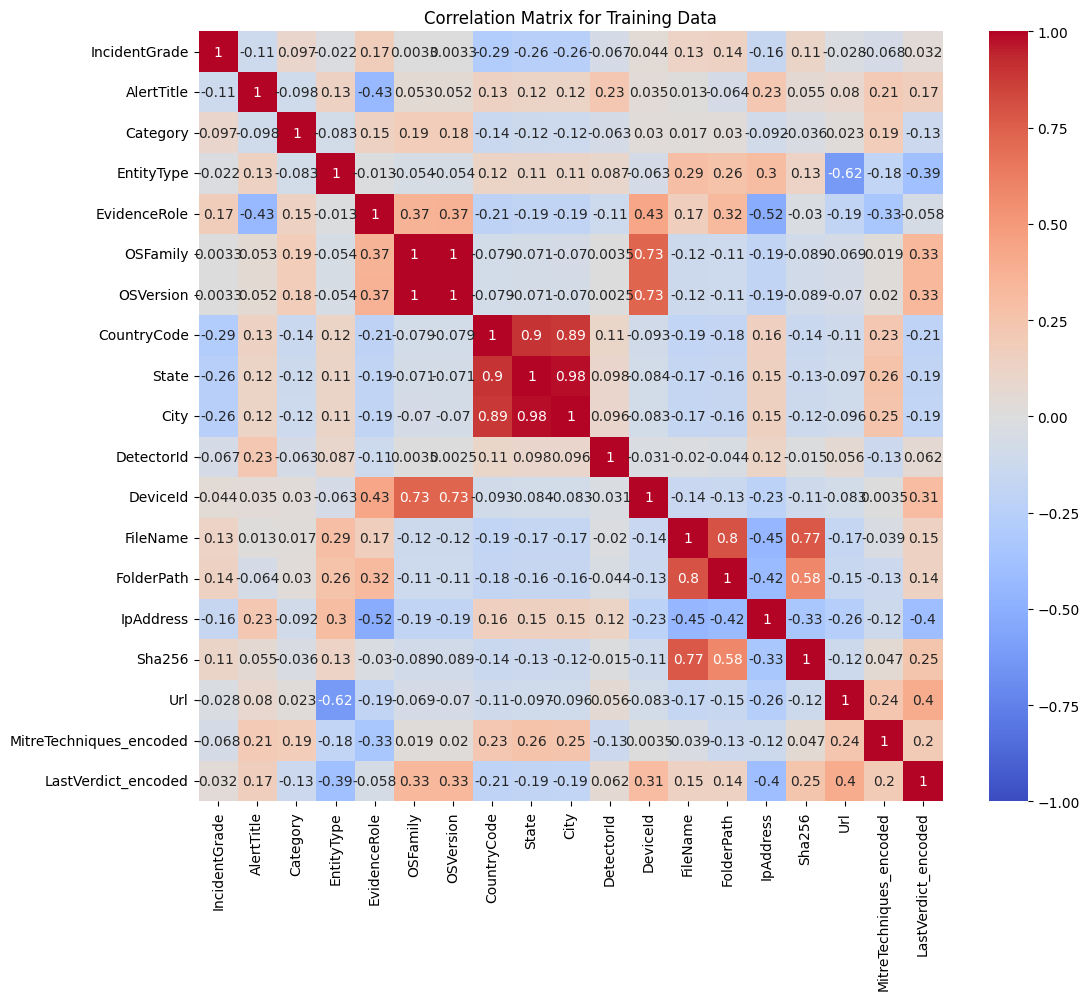

Categorical columns: Index(['IncidentGrade', 'Category', 'MitreTechniques', 'EntityType',
       'EvidenceRole', 'LastVerdict'],
      dtype='object')
Numerical columns: Index(['AlertTitle', 'OSFamily', 'OSVersion', 'CountryCode', 'State', 'City',
       'DetectorId', 'DeviceId', 'FileName', 'FolderPath', 'IpAddress',
       'Sha256', 'Url'],
      dtype='object')
Label encoded DataFrame head:
    IncidentGrade  AlertTitle  Category MitreTechniques  EntityType  \
0              0         563        11           T1021          32   
1              0         563        11           T1047          32   

   EvidenceRole  OSFamily  OSVersion LastVerdict  CountryCode  ...   City  \
0             0         5         66  Suspicious          242  ...  10630   
1             0         5         66  Suspicious          242  ...  10630   

   DetectorId  DeviceId  FileName  FolderPath  IpAddress  Sha256     Url  \
0         524     98799    289573      117668     360606  138268  160396   
1      

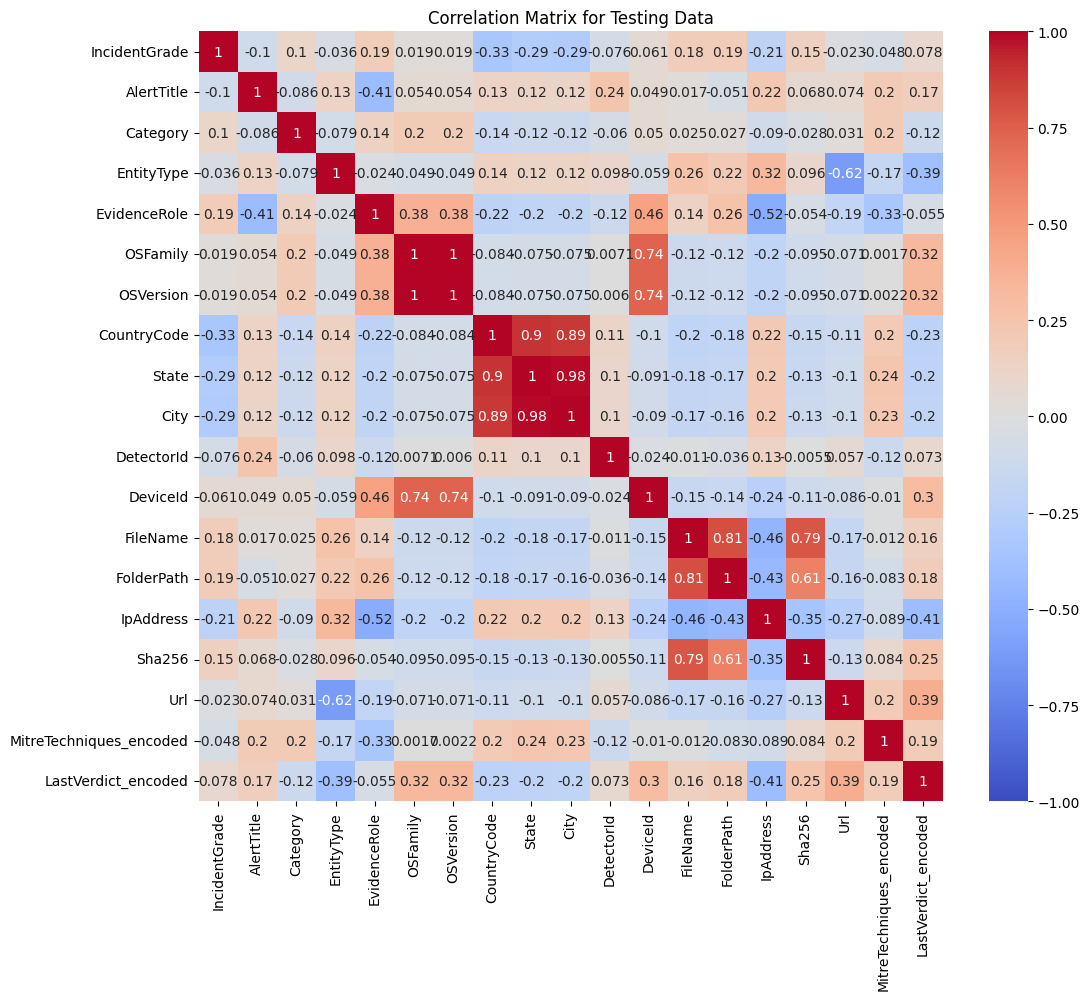

In [ ]:
#find correlation between variables to do Imputation for mitretechniques and lastverdict
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

def preprocess_and_plot(df, title, label_encoders=None):
    # Create a copy of the DataFrame to avoid modifying the original
    df = df.copy()

    # Identify categorical and numerical columns
    categorical_cols = df.select_dtypes(include=['object']).columns
    numerical_cols = df.select_dtypes(include=['number']).columns

    print("Categorical columns:", categorical_cols)
    print("Numerical columns:", numerical_cols)

    # Handle missing values for categorical columns and convert them to strings
    df[categorical_cols] = df[categorical_cols].astype(str).fillna('Unknown')

    # Frequency Encoding for 'MitreTechniques' and 'LastVerdict'
    if 'MitreTechniques' in df.columns:
        frequency_mitre = df['MitreTechniques'].value_counts()
        df['MitreTechniques_encoded'] = df['MitreTechniques'].map(frequency_mitre).fillna(0)

    if 'LastVerdict' in df.columns:
        frequency_last_verdict = df['LastVerdict'].value_counts()
        df['LastVerdict_encoded'] = df['LastVerdict'].map(frequency_last_verdict).fillna(0)

    # Initialize label encoders if not provided
    if label_encoders is None:
        label_encoders = {}
        for column in categorical_cols:
            if column not in ['MitreTechniques', 'LastVerdict']:  # Skip columns handled differently
                le = LabelEncoder()
                df[column] = le.fit_transform(df[column])
                label_encoders[column] = le
    else:
        for column in label_encoders:
            if column in df.columns:
                le = label_encoders[column]
                df[column] = le.transform(df[column])
            else:
                print(f"Warning: Column {column} not found in DataFrame.")

    # Debug information to check label encoding
    print("Label encoded DataFrame head:\n", df.head(2))

    # Ensure all data is numeric before calculating correlation matrix
    df_numeric = df.select_dtypes(include=['number']).copy()  # Use only numeric columns

    # Compute Correlation Matrix
    correlation_matrix = df_numeric.corr()

    # Plot Correlation Matrix
    plt.figure(figsize=(12, 10))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title(title)
    plt.show()

    return df, label_encoders

# Apply the function to the training DataFrame
train_df, label_encoders = preprocess_and_plot(train_df, 'Correlation Matrix for Training Data')

# Check if label encoders were returned
if label_encoders:
    # Apply the function to the test DataFrame with the same label encoders
    test_df, _ = preprocess_and_plot(test_df, 'Correlation Matrix for Testing Data', label_encoders=label_encoders)
else:
    print("Label encoders were not initialized. Please check the training DataFrame processing.")

# At this point, train_df and test_df have been updated with encoded values and you can use them for further processing or modeling


In [ ]:
train_df.head(10)

,IncidentGrade,AlertTitle,Category,MitreTechniques,EntityType,EvidenceRole,OSFamily,OSVersion,LastVerdict,CountryCode,...,City,DetectorId,DeviceId,FileName,FolderPath,IpAddress,Sha256,Url,MitreTechniques_encoded,LastVerdict_encoded
0,2,6,10,UNKNOWN,15,1,5,66,UNKNOWN,31,...,3,7,98799,289573,117668,27,138268,160396,1190844,1409425
1,1,43,7,UNKNOWN,32,0,5,66,UNKNOWN,242,...,10630,58,98799,289573,117668,360606,138268,160396,1190844,1409425
2,1,298,10,T1189,31,1,5,66,Suspicious,242,...,10630,423,98799,289573,117668,360606,138268,68652,3748,322912
3,0,2,1,UNKNOWN,31,1,5,66,Suspicious,242,...,10630,2,98799,289573,117668,360606,138268,13,1190844,322912
4,2,74,6,UNKNOWN,32,0,5,66,UNKNOWN,242,...,10630,9,98799,289573,117668,360606,138268,160396,1190844,1409425
5,1,0,10,T1078,15,1,5,66,UNKNOWN,8,...,3,0,98799,289573,117668,30410,138268,160396,100551,1409425
6,1,0,10,T1078.004,15,1,5,66,UNKNOWN,8,...,3,0,98799,289573,117668,30410,138268,160396,75061,1409425
7,0,2,1,UNKNOWN,31,1,5,66,Suspicious,242,...,10630,2,98799,289573,117668,360606,138268,3306,1190844,322912
8,0,3919,7,UNKNOWN,21,0,5,66,UNKNOWN,242,...,10630,313,98799,289573,117668,360606,138268,160396,1190844,1409425
9,0,4,16,UNKNOWN,27,1,5,66,Suspicious,242,...,10630,3,98799,0,1694,360606,0,160396,1190844,322912


In [ ]:
train_df["OSVersion"].nunique()

58

In [ ]:
#imputation by features after finding correlation between independent variables with LV and MT
import pandas as pd

# Impute MitreTechniques with global mode fallback
def impute_mitre_techniques(df):
    # Calculate global mode for 'MitreTechniques' excluding 'UNKNOWN'
    global_mode = df[df['MitreTechniques'] != 'UNKNOWN']['MitreTechniques'].mode()[0]

    # Function to replace 'UNKNOWN' with the most frequent MitreTechnique in the group
    def impute_mode(group):
        mode = group[group != 'UNKNOWN'].mode()
        if not mode.empty:
            return group.replace('UNKNOWN', mode[0])
        else:
            return group.replace('UNKNOWN', global_mode)

    # Group by correlated features and apply imputation
    df['MitreTechniques'] = df.groupby(['Category', 'Url', 'EvidenceRole','State',"EntityType","City","AlertTitle"])['MitreTechniques'].transform(impute_mode)

    # Ensure no 'UNKNOWN' remains by filling remaining with global mode
    df['MitreTechniques'].replace('UNKNOWN', global_mode, inplace=True)

    return df

# Impute LastVerdict with global mode fallback
def impute_lastverdict(df):
    # Calculate global mode for 'LastVerdict' excluding 'UNKNOWN'
    global_mode = df[df['LastVerdict'] != 'UNKNOWN']['LastVerdict'].mode()[0]

    # Function to replace 'UNKNOWN' with the most frequent LastVerdict in the group
    def impute_mode(group):
        mode = group[group != 'UNKNOWN'].mode()
        if not mode.empty:
            return group.replace('UNKNOWN', mode[0])
        else:
            return group.replace('UNKNOWN', global_mode)

    # Group by correlated features and apply imputation
    df['LastVerdict'] = df.groupby(['AlertTitle', 'MitreTechniques', 'OSFamily', 'OSVersion',
                                    'DeviceId', 'FileName', 'FolderPath', 'Sha256', 'Url'])['LastVerdict'].transform(impute_mode)

    # Ensure no 'UNKNOWN' remains by filling remaining with global mode
    df['LastVerdict'].replace('UNKNOWN', global_mode, inplace=True)

    return df

# Apply frequency encoding function as before
def apply_frequency_encoding(df, column_name):
    frequency = df[column_name].value_counts().to_dict()
    df[column_name + '_encoded'] = df[column_name].map(frequency)
    return df

# Optimized function to handle both imputations
def process_and_impute(df):
    # Impute MitreTechniques first
    df = impute_mitre_techniques(df)

    # Then impute LastVerdict
    df = impute_lastverdict(df)

    # Apply frequency encoding
    df = apply_frequency_encoding(df, 'MitreTechniques')
    df = apply_frequency_encoding(df, 'LastVerdict')

    return df

# Apply the processing function to your DataFrames
train_df = process_and_impute(train_df)
test_df = process_and_impute(test_df)

# Display the processed DataFrames
print("Processed Training DataFrame:")
print(train_df[['MitreTechniques', 'LastVerdict']].head(10))
print("\nProcessed Test DataFrame:")
print(test_df[['MitreTechniques', 'LastVerdict']].head(10))


Processed Training DataFrame:
  MitreTechniques LastVerdict
0       T1566.002  Suspicious
1       T1566.002  Suspicious
2           T1189  Suspicious
3       T1566.002  Suspicious
4       T1566.002  Suspicious
5           T1078  Suspicious
6       T1078.004  Suspicious
7       T1566.002  Suspicious
8       T1566.002  Suspicious
9       T1566.002  Suspicious

Processed Test DataFrame:
  MitreTechniques LastVerdict
0           T1021  Suspicious
1           T1047  Suspicious
2           T1105  Suspicious
3       T1569.002  Suspicious
4       T1566.002  Suspicious
5           T1021  Suspicious
6       T1027.002  Suspicious
7       T1027.005  Suspicious
8           T1105  Suspicious
9           T1078  Suspicious


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import joblib

# Single line to save both train_df and test_df in Google Drive
joblib.dump(train_df, '/content/drive/My Drive/train_df.pkl'), joblib.dump(test_df, '/content/drive/My Drive/test_df.pkl')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


(['/content/drive/My Drive/train_df.pkl'],
 ['/content/drive/My Drive/test_df.pkl'])

In [ ]:
#Mitre Techniques positive correlation with Category,Alert Title,LastVerdict,CountryCode,State,City ,Url     and negative correlation with EntityType,Evidence Role,Detector Id,folderpath,Ipaddress
#LastVerdict positive correlation with Alert Title,Mitre Techniques,OSfamily,OSversion,deviceId,filename,folderpath,sha256,url  and  negative correlation withcategory,Entity Type,Countrycode ,state,city.Ipaddress

In [ ]:
train_df.columns

Index(['IncidentGrade', 'AlertTitle', 'Category', 'MitreTechniques',
       'EntityType', 'EvidenceRole', 'OSFamily', 'OSVersion', 'LastVerdict',
       'CountryCode', 'State', 'City', 'DetectorId', 'DeviceId', 'FileName',
       'FolderPath', 'IpAddress', 'Sha256', 'Url', 'MitreTechniques_encoded',
       'LastVerdict_encoded'],
      dtype='object')

In [ ]:
# Dropping the 'MitreTechniques_encoded' and 'LastVerdict_encoded' columns from both DataFrames after frequency encoding since used to find correlation

# Drop columns from the training DataFrame
train_df = train_df.drop(columns=['MitreTechniques_encoded', 'LastVerdict_encoded'])

# Drop columns from the testing DataFrame
test_df = test_df.drop(columns=['MitreTechniques_encoded', 'LastVerdict_encoded'])




In [ ]:
#Feature Engineering(combining CountryCode, State, and City  OSFamily and OSVersion  FileName and FolderPath)
import pandas as pd

def combine_features(df):
    # Ensure string type for concatenation
    df['Country_State_City'] = df[['CountryCode', 'State', 'City']].astype(str).agg('-'.join, axis=1)
    df['OS_Family_Version'] = df[['OSFamily', 'OSVersion']].astype(str).agg('-'.join, axis=1)
    df['File_Folder'] = df[['FileName', 'FolderPath']].astype(str).agg('-'.join, axis=1)

    # Optionally drop original columns if they are no longer needed
    df = df.drop(columns=['CountryCode', 'State', 'City', 'OSFamily', 'OSVersion', 'FileName', 'FolderPath'])

    return df

# Apply the feature combination to both training and test DataFrames
train_df = combine_features(train_df)
test_df = combine_features(test_df)

# Check the results
print("Train DataFrame columns after combining features:", train_df.columns)
print("Test DataFrame columns after combining features:", test_df.columns)


Train DataFrame columns after combining features: Index(['IncidentGrade', 'AlertTitle', 'Category', 'MitreTechniques',
       'EntityType', 'EvidenceRole', 'LastVerdict', 'DetectorId', 'DeviceId',
       'IpAddress', 'Sha256', 'Url', 'Country_State_City', 'OS_Family_Version',
       'File_Folder'],
      dtype='object')
Test DataFrame columns after combining features: Index(['IncidentGrade', 'AlertTitle', 'Category', 'MitreTechniques',
       'EntityType', 'EvidenceRole', 'LastVerdict', 'DetectorId', 'DeviceId',
       'IpAddress', 'Sha256', 'Url', 'Country_State_City', 'OS_Family_Version',
       'File_Folder'],
      dtype='object')


In [ ]:
print(train_df["Country_State_City"].nunique())
print(test_df["Country_State_City"].nunique())
print(train_df["OS_Family_Version"].nunique())
print(test_df["OS_Family_Version"].nunique())
print(train_df["File_Folder"].nunique())
print(test_df["File_Folder"].nunique())


10750
7495
59
44
281376
147662


In [ ]:
#labelecoding for OS_Family_Version
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Assuming train_df and test_df are already loaded as DataFrames
# Example:
# train_df = pd.read_csv('train.csv')
# test_df = pd.read_csv('test.csv')

# Check if 'OS_Family_Version' column exists
if 'OS_Family_Version' not in train_df.columns:
    raise ValueError("'OS_Family_Version' column is missing in train_df")

# Initialize LabelEncoder
le = LabelEncoder()

# Fit the LabelEncoder on the training data
train_df['OS_Family_Version_encoded'] = le.fit_transform(train_df['OS_Family_Version'])

# Function to safely encode test data
def safe_transform(le, values):
    # If the value is not seen during fit, return -1
    unseen_value = -1
    return np.array([le.transform([val])[0] if val in le.classes_ else unseen_value for val in values])

# Apply the safe_transform function to test data
test_df['OS_Family_Version_encoded'] = safe_transform(le, test_df['OS_Family_Version'])

# Check the result
print(train_df.head(2))
print(test_df.head(2))


   IncidentGrade  AlertTitle  Category MitreTechniques  EntityType  \
0              2           6        10       T1566.002          15   
1              1          43         7       T1566.002          32   

   EvidenceRole LastVerdict  DetectorId  DeviceId  IpAddress  Sha256     Url  \
0             1  Suspicious           7     98799         27  138268  160396   
1             0  Suspicious          58     98799     360606  138268  160396   

  Country_State_City OS_Family_Version    File_Folder  \
0             31-6-3              5-66  289573-117668   
1     242-1445-10630              5-66  289573-117668   

   OS_Family_Version_encoded  
0                         58  
1                         58  
   IncidentGrade  AlertTitle  Category MitreTechniques  EntityType  \
0              0         563        11           T1021          32   
1              0         563        11           T1047          32   

   EvidenceRole LastVerdict  DetectorId  DeviceId  IpAddress  Sha256    

In [ ]:
print(train_df["OS_Family_Version_encoded"].nunique())

59


In [ ]:
# Dropping the 'OS_Family_Version column from both DataFrames after label encoding

# Drop columns from the training DataFrame
train_df = train_df.drop(columns=["OS_Family_Version"])

# Drop columns from the testing DataFrame
test_df = test_df.drop(columns=['OS_Family_Version'])




In [ ]:
train_df.shape

(1923060, 15)

In [ ]:
#Country_State_City and  File_Folder frequency encoding due to high unique values
import numpy as np
import pandas as pd

# Define chunk size
chunk_size = 100000  # Adjust this based on your memory limitations

# Assuming train_df and test_df are already loaded with data

# Create frequency dictionaries for 'Country_State_City' and 'File_Folder' from the entire train_df
country_state_city_freq = train_df['Country_State_City'].value_counts().to_dict()
file_folder_freq = train_df['File_Folder'].value_counts().to_dict()

# Define a function to apply frequency encoding for both columns
def apply_frequency_encoding(df_chunk, country_state_city_freq, file_folder_freq):
    # Frequency encoding for 'Country_State_City'
    df_chunk['Country_State_City_encoded'] = df_chunk['Country_State_City'].map(country_state_city_freq).fillna(0)

    # Frequency encoding for 'File_Folder'
    df_chunk['File_Folder_encoded'] = df_chunk['File_Folder'].map(file_folder_freq).fillna(0)

    return df_chunk

# Process the train_df in chunks using numpy's array_split
train_df_encoded = pd.DataFrame()  # Empty DataFrame to store the processed chunks
for chunk in np.array_split(train_df, len(train_df) // chunk_size):
    chunk_encoded = apply_frequency_encoding(chunk, country_state_city_freq, file_folder_freq)
    train_df_encoded = pd.concat([train_df_encoded, chunk_encoded], ignore_index=True)

# Process the test_df in chunks using numpy's array_split
test_df_encoded = pd.DataFrame()  # Empty DataFrame to store the processed chunks
for chunk in np.array_split(test_df, len(test_df) // chunk_size):
    chunk_encoded = apply_frequency_encoding(chunk, country_state_city_freq, file_folder_freq)
    test_df_encoded = pd.concat([test_df_encoded, chunk_encoded], ignore_index=True)

# Now you have memory-efficiently processed train_df_encoded and test_df_encoded


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [ ]:
train_df=train_df_encoded
test_df=test_df_encoded

In [ ]:
print(train_df["Country_State_City_encoded"].nunique())
print(train_df["File_Folder_encoded"].nunique())


300
202


In [ ]:
# Dropping the 'MitreTechniques' and 'LastVerdict' columns from both DataFrames after frequency encoding

# Drop columns from the training DataFrame
train_df = train_df.drop(columns=['Country_State_City', 'File_Folder'])

# Drop columns from the testing DataFrame
test_df = test_df.drop(columns=['Country_State_City', 'File_Folder'])




In [ ]:
train_df.shape

(1923060, 15)

In [ ]:
test_df.shape

(1026210, 15)

In [ ]:
print(test_df.duplicated().sum())
print(train_df.duplicated().sum())

98228
207499


In [ ]:
train_df.drop_duplicates(inplace=True)
test_df.drop_duplicates(inplace=True)

In [ ]:
print(train_df.shape)
print(test_df.shape)

(1715561, 15)
(927982, 15)


In [ ]:
train_df.head(5)

,IncidentGrade,AlertTitle,Category,MitreTechniques,EntityType,EvidenceRole,LastVerdict,DetectorId,DeviceId,IpAddress,Sha256,Url,OS_Family_Version_encoded,Country_State_City_encoded,File_Folder_encoded
0,2,6,10,T1566.002,15,1,Suspicious,7,98799,27,138268,160396,58,20,1429200
1,1,43,7,T1566.002,32,0,Suspicious,58,98799,360606,138268,160396,58,1712754,1429200
2,1,298,10,T1189,31,1,Suspicious,423,98799,360606,138268,68652,58,1712754,1429200
3,0,2,1,T1566.002,31,1,Suspicious,2,98799,360606,138268,13,58,1712754,1429200
4,2,74,6,T1566.002,32,0,Suspicious,9,98799,360606,138268,160396,58,1712754,1429200


In [ ]:
print(train_df["LastVerdict"].nunique())
print(test_df["LastVerdict"].nunique())
print(train_df["MitreTechniques"].nunique())
print(test_df["MitreTechniques"].nunique())

5
4
432
400


In [ ]:
#print(train_df["LastVerdict"].value_counts())
#print(test_df["LastVerdict"].value_counts())
print(train_df["MitreTechniques"].value_counts())
print(test_df["MitreTechniques"].value_counts())

MitreTechniques
T1566.002    1129700
T1078         103303
T1078.004      75058
T1566          26737
T1071          21900
              ...   
T0826              1
T0878              1
T1499.004          1
T0837              1
T1464              1
Name: count, Length: 432, dtype: int64
MitreTechniques
T1566.002    589180
T1078         56161
T1078.004     41638
T1566         14973
T1071         14551
              ...  
T1603             1
T0872             1
T0831             1
T0837             1
T1619             1
Name: count, Length: 400, dtype: int64


In [ ]:
#freq encoding for MitreTechniques , label encoding for Last Verdict
from sklearn.preprocessing import LabelEncoder

# Label Encoding for 'LastVerdict' since it has a low number of unique categories
def label_encode(df, column_name):
    le = LabelEncoder()
    df[column_name + '_encoded'] = le.fit_transform(df[column_name])
    return df

# Frequency Encoding for 'MitreTechniques'
def frequency_encode(df, column_name):
    freq_encoding = df[column_name].value_counts().to_dict()
    df[column_name + '_encoded'] = df[column_name].map(freq_encoding)
    return df

# Apply encoding to both DataFrames
def encode_dataframes(train_df, test_df):
    # Label encode 'LastVerdict'
    train_df = label_encode(train_df, 'LastVerdict')
    test_df = label_encode(test_df, 'LastVerdict')

    # Frequency encode 'MitreTechniques'
    train_df = frequency_encode(train_df, 'MitreTechniques')
    test_df = frequency_encode(test_df, 'MitreTechniques')

    return train_df, test_df

# Apply the encoding to both train and test DataFrames
train_df, test_df = encode_dataframes(train_df, test_df)

# Check the results
print("Train DataFrame with encoded columns:")
print(train_df[['LastVerdict', 'LastVerdict_encoded', 'MitreTechniques', 'MitreTechniques_encoded']].head(10))

print("\nTest DataFrame with encoded columns:")
print(test_df[['LastVerdict', 'LastVerdict_encoded', 'MitreTechniques', 'MitreTechniques_encoded']].head(10))


Train DataFrame with encoded columns:
  LastVerdict  LastVerdict_encoded MitreTechniques  MitreTechniques_encoded
0  Suspicious                    4       T1566.002                  1129700
1  Suspicious                    4       T1566.002                  1129700
2  Suspicious                    4           T1189                     3738
3  Suspicious                    4       T1566.002                  1129700
4  Suspicious                    4       T1566.002                  1129700
5  Suspicious                    4           T1078                   103303
6  Suspicious                    4       T1078.004                    75058
7  Suspicious                    4       T1566.002                  1129700
8  Suspicious                    4       T1566.002                  1129700
9  Suspicious                    4       T1566.002                  1129700

Test DataFrame with encoded columns:
  LastVerdict  LastVerdict_encoded MitreTechniques  MitreTechniques_encoded
0  Suspiciou

In [ ]:

# Drop columns from the training DataFrame
train_df = train_df.drop(columns=['LastVerdict', 'MitreTechniques'])

# Drop columns from the testing DataFrame
test_df = test_df.drop(columns=['LastVerdict', 'MitreTechniques'])

In [ ]:
# Loop over the dataframes
for name, df in [('train_df', train_df), ('test_df', test_df)]:
    # Select columns with data types other than 'object'
    non_object_cols = df.select_dtypes(exclude='object')

    # Apply nunique() to each column
    nunique_counts = non_object_cols.nunique()

    # Display the results
    print(f"Unique values in each column ({name}):\n{nunique_counts}\n")


Unique values in each column (train_df):
IncidentGrade                      3
AlertTitle                     79952
Category                          20
EntityType                        33
EvidenceRole                       2
DetectorId                      7813
DeviceId                       75557
IpAddress                     285957
Sha256                        106416
Url                           123252
OS_Family_Version_encoded         59
Country_State_City_encoded       300
File_Folder_encoded              202
LastVerdict_encoded                5
MitreTechniques_encoded          269
dtype: int64

Unique values in each column (test_df):
IncidentGrade                      3
AlertTitle                     42265
Category                          19
EntityType                        29
EvidenceRole                       2
DetectorId                      5970
DeviceId                       46260
IpAddress                     173786
Sha256                         59446
Url              

In [ ]:
# Convert features to categorical types
train_df['IncidentGrade'] = train_df['IncidentGrade'].astype('category')
train_df['Category'] = train_df['Category'].astype('category')
train_df['EntityType'] = train_df['EntityType'].astype('category')
train_df['EvidenceRole'] = train_df['EvidenceRole'].astype('category')
train_df['LastVerdict_encoded'] = train_df['LastVerdict_encoded'].astype('category')
train_df['MitreTechniques_encoded'] = train_df['MitreTechniques_encoded'].astype('category')
train_df["Country_State_City_encoded"]=train_df["Country_State_City_encoded"].astype('category')
train_df["File_Folder_encoded"]=train_df["File_Folder_encoded"].astype('category')
train_df["OS_Family_Version_encoded"]=train_df["OS_Family_Version_encoded"].astype('category')

test_df['IncidentGrade'] = test_df['IncidentGrade'].astype('category')
test_df['Category'] = test_df['Category'].astype('category')
test_df['EntityType'] = test_df['EntityType'].astype('category')
test_df['EvidenceRole'] = test_df['EvidenceRole'].astype('category')
test_df['LastVerdict_encoded'] = test_df['LastVerdict_encoded'].astype('category')
test_df['MitreTechniques_encoded'] = test_df['MitreTechniques_encoded'].astype('category')
test_df["Country_State_City_encoded"]=test_df["Country_State_City_encoded"].astype('category')
test_df["File_Folder_encoded"]=test_df["File_Folder_encoded"].astype('category')
test_df["OS_Family_Version_encoded"]=test_df["OS_Family_Version_encoded"].astype('category')


In [ ]:
#train_df1=train_df.copy()
#train_df1.to_csv('/content/drive/MyDrive/df1.csv', index=False, compression='gzip')

In [ ]:
# Write train_df and test_df directly to compressed CSV files
train_df.to_csv('/content/drive/MyDrive/train_df1.csv', index=False, compression='gzip')
test_df.to_csv('/content/drive/MyDrive/test_df2.csv', index=False, compression='gzip')


In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/train_df1.csv', compression='gzip')
test_df = pd.read_csv('/content/drive/MyDrive/test_df2.csv', compression='gzip')

In [ ]:
print(train_df.shape)
print(test_df.shape)

(1715561, 15)
(927982, 15)


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1715561 entries, 0 to 1715560
Data columns (total 15 columns):
 #   Column                      Dtype   
---  ------                      -----   
 0   IncidentGrade               category
 1   AlertTitle                  int64   
 2   Category                    category
 3   EntityType                  category
 4   EvidenceRole                category
 5   DetectorId                  int64   
 6   DeviceId                    int64   
 7   IpAddress                   int64   
 8   Sha256                      int64   
 9   Url                         int64   
 10  OS_Family_Version_encoded   category
 11  Country_State_City_encoded  category
 12  File_Folder_encoded         category
 13  LastVerdict_encoded         category
 14  MitreTechniques_encoded     category
dtypes: category(9), int64(6)
memory usage: 98.2 MB


In [ ]:
import pandas as pd

# Function to remove outliers using IQR method for a single column
def remove_outliers_by_iqr(df, column):
    """
    Removes outliers from a column in the DataFrame based on the IQR method.

    Parameters:
    df (pd.DataFrame): The input DataFrame.
    column (str): The name of the column to check for outliers.

    Returns:
    pd.DataFrame: DataFrame with outliers removed for the specified column.
    """
    # Calculate Q1 (25th percentile) and Q3 (75th percentile)
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    # Define lower and upper bound for outlier detection
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filter rows where the column values are within the IQR bounds
    df_clean = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

    return df_clean

# Function to apply IQR outlier removal for multiple numerical columns
def remove_outliers_in_dataframe(df, numerical_columns):
    """
    Applies IQR outlier removal for multiple columns in the DataFrame.

    Parameters:
    df (pd.DataFrame): The input DataFrame.
    numerical_columns (list): List of numerical columns to apply IQR outlier removal.

    Returns:
    pd.DataFrame: DataFrame with outliers removed for the specified numerical columns.
    """
    for col in numerical_columns:
        df = remove_outliers_by_iqr(df, col)
    return df

# Example DataFrames (train and test)
# train_df and test_df should be predefined DataFrames containing your dataset
# Replace with the actual DataFrame loading code, e.g., pd.read_csv(...)

# List of numerical columns to check for outliers
numerical_columns = ['AlertTitle', 'DetectorId', 'DeviceId', 'IpAddress', 'Sha256', 'Url']

# Apply IQR outlier removal to both train_df and test_df
train_df = remove_outliers_in_dataframe(train_df, numerical_columns)
test_df= remove_outliers_in_dataframe(test_df, numerical_columns)

# Displaying statistics of the cleaned DataFrame after outlier removal to verify
print("Train DataFrame after outlier removal:")
print(train_df.head(10))

print("\nTest DataFrame after outlier removal:")
print(test_df.head(10))


Train DataFrame after outlier removal:
   IncidentGrade  AlertTitle Category EntityType EvidenceRole  DetectorId  \
0              2           6       10         15            1           7   
1              1          43        7         32            0          58   
4              2          74        6         32            0           9   
5              1           0       10         15            1           0   
6              1           0       10         15            1           0   
10             2           3       10         32            0           4   
12             2         373        6          5            0           9   
13             2           3       10         15            1           4   
14             1         284        9         15            1          17   
16             0          11       10         21            1          13   

    DeviceId  IpAddress  Sha256     Url OS_Family_Version_encoded  \
0      98799         27  138268  160396     

In [ ]:
print(train_df.shape)
print(test_df.shape)

(774784, 15)
(418695, 15)


In [ ]:
print(train_df.duplicated().sum())
print(test_df.duplicated().sum())

75
0


In [ ]:
train_df.drop_duplicates(inplace=True)
test_df.drop_duplicates(inplace=True)

In [ ]:
print(train_df.shape)
print(test_df.shape)

(774709, 15)
(418695, 15)


In [ ]:
train_df.head(5)

,IncidentGrade,AlertTitle,Category,EntityType,EvidenceRole,DetectorId,DeviceId,IpAddress,Sha256,Url,OS_Family_Version_encoded,Country_State_City_encoded,File_Folder_encoded,LastVerdict_encoded,MitreTechniques_encoded
0,2,6,10,15,1,7,98799,27,138268,160396,58,20,1429200,4,1129700
1,1,43,7,32,0,58,98799,360606,138268,160396,58,1712754,1429200,4,1129700
4,2,74,6,32,0,9,98799,360606,138268,160396,58,1712754,1429200,4,1129700
5,1,0,10,15,1,0,98799,30410,138268,160396,58,1678,1429200,4,103303
6,1,0,10,15,1,0,98799,30410,138268,160396,58,1678,1429200,4,75058


In [ ]:
# Identify and handle class imbalance
import pandas as pd

# Check class distribution in training data
train_class_distribution = train_df['IncidentGrade'].value_counts()
print("Training Data Class Distribution:")
print(train_class_distribution)

# Check class distribution in test data
test_class_distribution = test_df['IncidentGrade'].value_counts()
print("Test Data Class Distribution:")
print(test_class_distribution)


Training Data Class Distribution:
IncidentGrade
0    296614
1    266768
2    211327
Name: count, dtype: int64
Test Data Class Distribution:
IncidentGrade
0    149573
1    148792
2    120330
Name: count, dtype: int64


In [ ]:
#split data with stratification

from sklearn.model_selection import train_test_split

# Assuming 'train_df' is your original dataset and 'IncidentGrade' is your target
X = train_df.drop('IncidentGrade', axis=1)
y = train_df['IncidentGrade']

# Split data into train and test sets with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [ ]:
#SMOTE(to handle imbalance classes)

from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Initialize SMOTE, StandardScaler, and SimpleImputer
smote = SMOTE(random_state=42)
scaler = StandardScaler()
imputer = SimpleImputer(strategy='mean')

# Fit imputer and scaler on the entire training data
imputer.fit(X_train)
scaler.fit(imputer.transform(X_train))

# Define the chunk size
chunk_size = 100000

# Initialize lists to store processed chunks
X_resampled_chunks = []
y_resampled_chunks = []

# Process training data in chunks
for start in range(0, len(X_train), chunk_size):
    end = min(start + chunk_size, len(X_train))
    X_chunk = X_train.iloc[start:end]
    y_chunk = y_train.iloc[start:end]

    # Handle missing values
    X_chunk = imputer.transform(X_chunk)

    # Standardize features
    X_chunk_scaled = scaler.transform(X_chunk)

    # Apply SMOTE
    X_resampled, y_resampled = smote.fit_resample(X_chunk_scaled, y_chunk)

    # Store the resampled chunks
    X_resampled_chunks.append(X_resampled)
    y_resampled_chunks.append(y_resampled)

# Concatenate all resampled chunks
X_resampled_final = np.concatenate(X_resampled_chunks, axis=0)
y_resampled_final = np.concatenate(y_resampled_chunks, axis=0)

# Create a DataFrame from the resampled data
train_resampled_df = pd.DataFrame(X_resampled_final, columns=X_train.columns)
train_resampled_df['IncidentGrade'] = y_resampled_final

# Print column names
print(train_resampled_df.columns)

# Optionally save the resampled DataFrame
train_resampled_df.to_csv('/content/drive/MyDrive/train_resampled_data.csv', index=False)

print("SMOTE applied to training data and saved.")


Index(['AlertTitle', 'Category', 'EntityType', 'EvidenceRole', 'DetectorId',
       'DeviceId', 'IpAddress', 'Sha256', 'Url', 'OS_Family_Version_encoded',
       'Country_State_City_encoded', 'File_Folder_encoded',
       'LastVerdict_encoded', 'MitreTechniques_encoded', 'IncidentGrade'],
      dtype='object')
SMOTE applied to training data and saved.


In [ ]:
train_resampled_df.shape

(711873, 15)

In [ ]:
X_resampled_final.shape

(711873, 14)

In [ ]:
y_resampled_final.shape

(711873,)

In [ ]:
print(train_resampled_df['IncidentGrade'].value_counts())

print(train_resampled_df.head(2))

IncidentGrade
0    237291
1    237291
2    237291
Name: count, dtype: int64
   AlertTitle  Category  EntityType  EvidenceRole  DetectorId  DeviceId  \
0   -0.310186  2.444271   -0.036682      0.095729   -0.776123       0.0   
1   -0.620309  0.278403   -0.036682      0.095729   -0.876976       0.0   

   IpAddress  Sha256  Url  OS_Family_Version_encoded  \
0  -0.294975     0.0  0.0                        0.0   
1   0.893086     0.0  0.0                        0.0   

   Country_State_City_encoded  File_Folder_encoded  LastVerdict_encoded  \
0                    0.608337             0.071906             0.131826   
1                   -1.645637             0.071906             0.131826   

   MitreTechniques_encoded  IncidentGrade  
0                 0.733195              0  
1                -1.326039              1  


In [ ]:
train_resampled_df.head(10)

,AlertTitle,Category,EntityType,EvidenceRole,DetectorId,DeviceId,IpAddress,Sha256,Url,OS_Family_Version_encoded,Country_State_City_encoded,File_Folder_encoded,LastVerdict_encoded,MitreTechniques_encoded,IncidentGrade
0,-0.310186,2.444271,-0.036682,0.095729,-0.776123,0.0,-0.294975,0.0,0.0,0.0,0.608337,0.071906,0.131826,0.733195,0
1,-0.620309,0.278403,-0.036682,0.095729,-0.876976,0.0,0.893086,0.0,0.0,0.0,-1.645637,0.071906,0.131826,-1.326039,1
2,-0.614636,0.278403,-0.036682,0.095729,-0.742505,0.0,0.050630,0.0,0.0,0.0,-1.641663,0.071906,0.131826,0.733195,0
3,-0.520086,-0.031007,-0.036682,0.095729,1.543503,0.0,0.212929,0.0,0.0,0.0,0.608337,0.071906,0.131826,0.733195,0
4,1.346326,-0.031007,-0.036682,0.095729,-0.171003,0.0,-0.737960,0.0,0.0,0.0,0.608337,0.071906,0.131826,0.733195,1
5,-0.554124,-2.506285,-0.036682,0.095729,0.770295,0.0,-0.443886,0.0,0.0,0.0,0.608337,0.071906,0.131826,-1.450149,1
6,-0.582489,-0.031007,-0.036682,0.095729,0.097939,0.0,-0.554595,0.0,0.0,0.0,0.608337,0.071906,0.131826,0.733195,2
7,-0.554124,-2.506285,-0.036682,0.095729,0.770295,0.0,0.678264,0.0,0.0,0.0,0.608337,0.071906,0.131826,-1.439258,0
8,1.809620,-0.031007,-0.036682,0.095729,-0.339092,0.0,-0.692579,0.0,0.0,0.0,0.608337,0.071906,0.131826,0.733195,0
9,-0.614636,0.278403,-0.036682,0.095729,-0.742505,0.0,-0.749792,0.0,0.0,0.0,-1.645219,0.071906,0.131826,0.733195,2


In [ ]:
# Check the number of unique values for all columns in train_resampled_df
nunique_values = train_resampled_df.nunique()

# Print the result
print(nunique_values)


AlertTitle                     11435
Category                         246
EntityType                        80
EvidenceRole                       7
DetectorId                       868
DeviceId                           1
IpAddress                     299324
Sha256                             1
Url                                1
OS_Family_Version_encoded          1
Country_State_City_encoded     34545
File_Folder_encoded              399
LastVerdict_encoded               13
MitreTechniques_encoded         2589
IncidentGrade                      3
dtype: int64


In [ ]:
train_resampled_df.drop(["DeviceId","Sha256","Url","OS_Family_Version_encoded"],axis=1,inplace=True)



KeyError: "['DeviceId', 'Sha256', 'Url', 'OS_Family_Version_encoded'] not found in axis"

In [ ]:
test_df.drop(['DeviceId','Sha256','Url','OS_Family_Version_encoded'],axis=1,inplace=True)

NameError: name 'test_resampled_df' is not defined

In [ ]:
print(train_resampled_df.shape)
print(test_df.shape)

(711873, 11)
(418695, 11)


In [ ]:
train_resampled_df.columns

Index(['AlertTitle', 'Category', 'EntityType', 'EvidenceRole', 'DetectorId',
       'IpAddress', 'Country_State_City_encoded', 'File_Folder_encoded',
       'LastVerdict_encoded', 'MitreTechniques_encoded', 'IncidentGrade'],
      dtype='object')

In [ ]:
#train_df.drop(['DeviceId','Sha256','Url','OS_Family_Version_encoded'],axis=1,inplace=True)
#test_df.drop(['DeviceId','Sha256','Url','OS_Family_Version_encoded'],axis=1,inplace=True)

In [97]:
#Model Selection and training
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score

# Define the top 10 features based on importance
features = ['AlertTitle', 'Category', 'EntityType', 'EvidenceRole', 'DetectorId',
            'IpAddress', 'Country_State_City_encoded', 'File_Folder_encoded',
            'LastVerdict_encoded', 'MitreTechniques_encoded']

# Define chunk size
chunk_size = 100000

# Function to process data in chunks and apply feature selection
def process_chunks(file_path, chunk_size, top_features):
    chunks = pd.read_csv(file_path, chunksize=chunk_size)
    for chunk in chunks:
        chunk = chunk[features + ['IncidentGrade']]  # Select only top features and target
        yield chunk

# Load and process the dataset in chunks
chunks = process_chunks('/content/drive/MyDrive/train_resampled_data.csv', chunk_size, features)
df = pd.concat(chunks, ignore_index=True)

# Separate features and target
X = df[features]
y = df['IncidentGrade']

# Split the data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Define pipelines for each model
pipeline_log_reg = Pipeline(steps=[
    ('classifier', LogisticRegression(max_iter=1000, solver='lbfgs', random_state=42))
])

pipeline_tree = Pipeline(steps=[
    ('classifier', DecisionTreeClassifier(random_state=42))
])

pipeline_rf = Pipeline(steps=[
    ('classifier', RandomForestClassifier(random_state=42))
])

pipeline_xgb = Pipeline(steps=[
    ('classifier', xgb.XGBClassifier(eval_metric='mlogloss', random_state=42))
])

# Train and evaluate each model
print("Baseline Model Evaluation:")

# Logistic Regression
pipeline_log_reg.fit(X_train, y_train)
y_pred_log_reg = pipeline_log_reg.predict(X_valid)
print("Logistic Regression Classification Report:")
print(classification_report(y_valid, y_pred_log_reg))
print("Confusion Matrix:")
print(confusion_matrix(y_valid, y_pred_log_reg))

# Decision Tree
pipeline_tree.fit(X_train, y_train)
y_pred_tree = pipeline_tree.predict(X_valid)
print("Decision Tree Classification Report:")
print(classification_report(y_valid, y_pred_tree))
print("Confusion Matrix:")
print(confusion_matrix(y_valid, y_pred_tree))

# Random Forest
pipeline_rf.fit(X_train, y_train)
y_pred_rf = pipeline_rf.predict(X_valid)
print("Random Forest Classification Report:")
print(classification_report(y_valid, y_pred_rf))
print("Confusion Matrix:")
print(confusion_matrix(y_valid, y_pred_rf))

# XGBoost
pipeline_xgb.fit(X_train, y_train)
y_pred_xgb = pipeline_xgb.predict(X_valid)
print("XGBoost Classification Report:")
print(classification_report(y_valid, y_pred_xgb))
print("Confusion Matrix:")
print(confusion_matrix(y_valid, y_pred_xgb))

# Compute precision, recall, and F1 score for each model
def evaluate_metrics(y_true, y_pred):
    print("Evaluation Metrics:")
    print(f"Macro F1 Score: {f1_score(y_true, y_pred, average='macro')}")
    print(f"Macro Precision: {precision_score(y_true, y_pred, average='macro')}")
    print(f"Macro Recall: {recall_score(y_true, y_pred, average='macro')}")
    print()

print("Evaluation Metrics for Logistic Regression:")
evaluate_metrics(y_valid, y_pred_log_reg)

print("Evaluation Metrics for Decision Tree:")
evaluate_metrics(y_valid, y_pred_tree)

print("Evaluation Metrics for Random Forest:")
evaluate_metrics(y_valid, y_pred_rf)

print("Evaluation Metrics for XGBoost:")
evaluate_metrics(y_valid, y_pred_xgb)


Baseline Model Evaluation:
Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.53      0.52     47458
           1       0.61      0.58      0.60     47458
           2       0.52      0.53      0.52     47459

    accuracy                           0.54    142375
   macro avg       0.55      0.54      0.55    142375
weighted avg       0.55      0.54      0.55    142375

Confusion Matrix:
[[24988 10325 12145]
 [ 8898 27552 11008]
 [15249  7194 25016]]
Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.85      0.84     47458
           1       0.82      0.81      0.82     47458
           2       0.85      0.83      0.84     47459

    accuracy                           0.83    142375
   macro avg       0.83      0.83      0.83    142375
weighted avg       0.83      0.83      0.83    142375

Confusion Matrix:
[[40360  4098  3000]
 [ 4732 38

In [98]:
from google.colab import files
import joblib

# Save the models to the local filesystem
joblib.dump(pipeline_rf, '/content/random_forest_model.joblib')
joblib.dump(pipeline_xgb, '/content/xgboost_model.joblib')

# Create download links for the local files
files.download('/content/random_forest_model.joblib')
files.download('/content/xgboost_model.joblib')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [100]:
#hypertuning for decision tree classifier
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score

# Define the top 10 features based on importance
features = ['AlertTitle', 'Category', 'EntityType', 'EvidenceRole', 'DetectorId',
            'IpAddress', 'Country_State_City_encoded', 'File_Folder_encoded',
            'LastVerdict_encoded', 'MitreTechniques_encoded']

# Define chunk size
chunk_size = 100000

# Function to process data in chunks and apply feature selection
def process_chunks(file_path, chunk_size, top_features):
    chunks = pd.read_csv(file_path, chunksize=chunk_size)
    for chunk in chunks:
        chunk = chunk[features + ['IncidentGrade']]  # Select only top features and target
        yield chunk

# Load and process the dataset in chunks
chunks = process_chunks('/content/drive/MyDrive/train_resampled_data.csv', chunk_size, features)
df = pd.concat(chunks, ignore_index=True)

# Separate features and target
X = df[features]
y = df['IncidentGrade']

# Split the data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Define the pipeline for Decision Tree
pipeline_tree = Pipeline(steps=[
    ('classifier', DecisionTreeClassifier(random_state=42))
])

# Define hyperparameters for grid search
param_grid_tree = {
    'classifier__max_depth': [None, 5, 10, 15, 20],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__criterion': ['gini', 'entropy']
}

# Initialize GridSearchCV
grid_search_tree = GridSearchCV(pipeline_tree, param_grid_tree, cv=3, scoring='f1_macro')

# Train and evaluate the Decision Tree model using GridSearchCV
print("Hyperparameter Tuning for Decision Tree:")

grid_search_tree.fit(X_train, y_train)
y_pred_tree = grid_search_tree.predict(X_valid)

print("Decision Tree - Best Parameters:")
print(grid_search_tree.best_params_)

print("Decision Tree Classification Report:")
print(classification_report(y_valid, y_pred_tree))

print("Confusion Matrix:")
print(confusion_matrix(y_valid, y_pred_tree))

# Compute precision, recall, and F1 score for the tuned Decision Tree
def evaluate_metrics(y_true, y_pred):
    print("Evaluation Metrics:")
    print(f"Macro F1 Score: {f1_score(y_true, y_pred, average='macro')}")
    print(f"Macro Precision: {precision_score(y_true, y_pred, average='macro')}")
    print(f"Macro Recall: {recall_score(y_true, y_pred, average='macro')}")
    print()

print("Evaluation Metrics for Tuned Decision Tree:")
evaluate_metrics(y_valid, y_pred_tree)


Hyperparameter Tuning for Decision Tree:
Decision Tree - Best Parameters:
{'classifier__criterion': 'gini', 'classifier__max_depth': 15, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 10}
Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.83      0.86     47458
           1       0.80      0.87      0.83     47458
           2       0.85      0.84      0.85     47459

    accuracy                           0.85    142375
   macro avg       0.85      0.85      0.85    142375
weighted avg       0.85      0.85      0.85    142375

Confusion Matrix:
[[39509  5437  2512]
 [ 1787 41420  4251]
 [ 2817  4913 39729]]
Evaluation Metrics for Tuned Decision Tree:
Evaluation Metrics:
Macro F1 Score: 0.8478329515411623
Macro Precision: 0.8500810171413175
Macro Recall: 0.8474662710707787



In [101]:
import joblib
from google.colab import files
# Save the best model from grid search
best_model = grid_search_tree.best_estimator_

# Specify the path to save the model
model_filename = '/content/drive/MyDrive/tuned_decision_tree_model.pkl'

# Save the model using joblib
joblib.dump(best_model, model_filename)

print(f"Model saved to {model_filename}")

# Download the saved model
files.download(model_filename)

Model saved to /content/drive/MyDrive/tuned_decision_tree_model.pkl


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#Neural Network
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Define the top 10 features based on importance
features =['AlertTitle', 'Category', 'EntityType', 'EvidenceRole', 'DetectorId',
       'IpAddress', 'Country_State_City_encoded', 'File_Folder_encoded',
       'LastVerdict_encoded', 'MitreTechniques_encoded']
# Function to process data in chunks and only select the top features
def process_and_split_data(file_path, chunk_size, features, target_column='IncidentGrade'):
    X_chunks = []
    y_chunks = []

    # Load and process data in chunks
    for chunk in pd.read_csv(file_path, usecols=features + [target_column], chunksize=chunk_size):
        X_chunk = chunk[features]
        y_chunk = chunk[target_column]
        X_chunks.append(X_chunk)
        y_chunks.append(y_chunk)

    # Concatenate chunks to form complete dataset
    X = pd.concat(X_chunks, ignore_index=True)
    y = pd.concat(y_chunks, ignore_index=True)

    return train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Load and split the dataset
chunk_size = 100000
X_train, X_valid, y_train, y_valid = process_and_split_data('/content/drive/MyDrive/train_resampled_data.csv', chunk_size, features)

# One-hot encode the target variable
lb = LabelBinarizer()
y_train_onehot = lb.fit_transform(y_train)
y_valid_onehot = lb.transform(y_valid)

# Define the neural network model
def create_model(input_shape):
    model = Sequential()
    model.add(Dense(128, input_shape=(input_shape,), activation='relu'))
    model.add(Dropout(0.3))  # Dropout for regularization
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(y_train_onehot.shape[1], activation='softmax'))  # Output layer for the number of classes
    return model

# Compile the model
model = create_model(X_train.shape[1])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Use mini-batch training to handle memory efficiently
batch_size = 4096  # Adjust based on available memory
epochs = 20

# Train the model
history = model.fit(X_train, y_train_onehot,
                    validation_data=(X_valid, y_valid_onehot),
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=2)

# Predict on validation set
y_pred_nn = model.predict(X_valid, batch_size=batch_size)
y_pred_nn_classes = y_pred_nn.argmax(axis=1)

# Classification report
print("Neural Network Classification Report:")
print(classification_report(y_valid, y_pred_nn_classes))

# Evaluate performance using confusion matrix
conf_matrix = tf.math.confusion_matrix(y_valid, y_pred_nn_classes)
print(f"Confusion Matrix:\n{conf_matrix}")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
140/140 - 4s - 30ms/step - accuracy: 0.5635 - loss: 0.8944 - val_accuracy: 0.6220 - val_loss: 0.7897
Epoch 2/20
140/140 - 5s - 35ms/step - accuracy: 0.6387 - loss: 0.7597 - val_accuracy: 0.7393 - val_loss: 0.6008
Epoch 3/20
140/140 - 4s - 27ms/step - accuracy: 0.7507 - loss: 0.5898 - val_accuracy: 0.7854 - val_loss: 0.4860
Epoch 4/20
140/140 - 6s - 42ms/step - accuracy: 0.7765 - loss: 0.5191 - val_accuracy: 0.7897 - val_loss: 0.4704
Epoch 5/20
140/140 - 5s - 33ms/step - accuracy: 0.7812 - loss: 0.4985 - val_accuracy: 0.7911 - val_loss: 0.4617
Epoch 6/20
140/140 - 5s - 36ms/step - accuracy: 0.7836 - loss: 0.4868 - val_accuracy: 0.7929 - val_loss: 0.4577
Epoch 7/20
140/140 - 5s - 37ms/step - accuracy: 0.7852 - loss: 0.4793 - val_accuracy: 0.7924 - val_loss: 0.4533
Epoch 8/20
140/140 - 5s - 38ms/step - accuracy: 0.7869 - loss: 0.4731 - val_accuracy: 0.7935 - val_loss: 0.4490
Epoch 9/20
140/140 - 4s - 26ms/step - accuracy: 0.7879 - loss: 0.4680 - val_accuracy: 0.7919 - val_loss:

In [ ]:
#hypertuning XGBboost
import pandas as pd
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

# Define the features and target
features = ['AlertTitle', 'Category', 'EntityType', 'EvidenceRole', 'DetectorId',
       'IpAddress', 'Country_State_City_encoded', 'File_Folder_encoded',
       'LastVerdict_encoded', 'MitreTechniques_encoded']

# Function to process data in chunks and concatenate them
def load_data_in_chunks(file_path, chunk_size):
    chunks = pd.read_csv(file_path, chunksize=chunk_size)
    df = pd.concat(chunks, ignore_index=True)
    return df

# Load data in chunks
chunk_size = 100000
file_path = '/content/drive/MyDrive/train_resampled_data.csv'

df = load_data_in_chunks(file_path, chunk_size)

# Define features and target
X = df[features]
y = df['IncidentGrade']

# Split the data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Define the hyperparameter grid for XGBoost
xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# Initialize XGBClassifier
xgb_model = xgb.XGBClassifier(eval_metric='mlogloss', random_state=42)

# Initialize RandomizedSearchCV for XGBoost
xgb_random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=xgb_param_grid,
                                        n_iter=10, cv=3, verbose=2, random_state=42, n_jobs=-1)

# Fit RandomizedSearchCV for XGBoost
xgb_random_search.fit(X_train, y_train)

# Best parameters for XGBoost
print("Best Hyperparameters for XGBoost:", xgb_random_search.best_params_)

# Evaluate tuned XGBoost model on the validation set
y_pred_xgb_tuned = xgb_random_search.predict(X_valid)
print("Tuned XGBoost Classification Report:")
print(classification_report(y_valid, y_pred_xgb_tuned))
print("Confusion Matrix:")
print(confusion_matrix(y_valid, y_pred_xgb_tuned))


Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Best Hyperparameters for XGBoost: {'subsample': 1.0, 'n_estimators': 300, 'max_depth': 9, 'learning_rate': 0.1, 'colsample_bytree': 1.0}
Tuned XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.84      0.86     47458
           1       0.82      0.87      0.84     47458
           2       0.85      0.85      0.85     47459

    accuracy                           0.85    142375
   macro avg       0.85      0.85      0.85    142375
weighted avg       0.85      0.85      0.85    142375

Confusion Matrix:
[[39747  4994  2717]
 [ 1911 41155  4392]
 [ 3050  4199 40210]]


In [ ]:
# Save the tuned XGBoost model
model_filename = '/content/xgb_tuned_model.joblib'
joblib.dump(xgb_random_search.best_estimator_, model_filename)
print(f"Model saved to {model_filename}")

# Download the saved model
files.download(model_filename)

Model saved to /content/xgb_tuned_model.joblib


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#save and download as pkl

In [ ]:
#HYPERTUNING RANDOM FOREST
import pandas as pd
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

# Define the features and target
features = ['AlertTitle', 'Category', 'EntityType', 'EvidenceRole', 'DetectorId',
            'IpAddress', 'Country_State_City_encoded', 'File_Folder_encoded',
            'LastVerdict_encoded', 'MitreTechniques_encoded']

# Function to process data in chunks and concatenate them
def load_data_in_chunks(file_path, chunk_size):
    chunks = pd.read_csv(file_path, chunksize=chunk_size)
    df = pd.concat(chunks, ignore_index=True)
    return df

# Load data in chunks
chunk_size = 100000
file_path = '/content/drive/MyDrive/train_resampled_data.csv'

df = load_data_in_chunks(file_path, chunk_size)

# Define features and target
X = df[features]
y = df['IncidentGrade']

# Split the data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Define the hyperparameter grid for Random Forest
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Initialize RandomForestClassifier
rf_model = RandomForestClassifier(random_state=42)

# Initialize RandomizedSearchCV for Random Forest
rf_random_search = RandomizedSearchCV(estimator=rf_model, param_distributions=rf_param_grid,
                                       n_iter=10, cv=3, verbose=2, random_state=42, n_jobs=-1)

# Fit RandomizedSearchCV for Random Forest
rf_random_search.fit(X_train, y_train)

# Best parameters for Random Forest
print("Best Hyperparameters for Random Forest:", rf_random_search.best_params_)

# Evaluate tuned Random Forest model on the validation set
y_pred_rf_tuned = rf_random_search.predict(X_valid)
print("Tuned Random Forest Classification Report:")
print(classification_report(y_valid, y_pred_rf_tuned))
print("Confusion Matrix:")
print(confusion_matrix(y_valid, y_pred_rf_tuned))


Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Hyperparameters for Random Forest: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 30, 'bootstrap': True}
Tuned Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.84      0.86     47458
           1       0.82      0.85      0.83     47458
           2       0.85      0.85      0.85     47459

    accuracy                           0.85    142375
   macro avg       0.85      0.85      0.85    142375
weighted avg       0.85      0.85      0.85    142375

Confusion Matrix:
[[40003  4864  2591]
 [ 2700 40216  4542]
 [ 3069  4205 40185]]


In [102]:
#model interpretation
import joblib

# Load the tuned XGBoost model
xgb_tuned_model = joblib.load('/xgb_tuned_model.joblib')


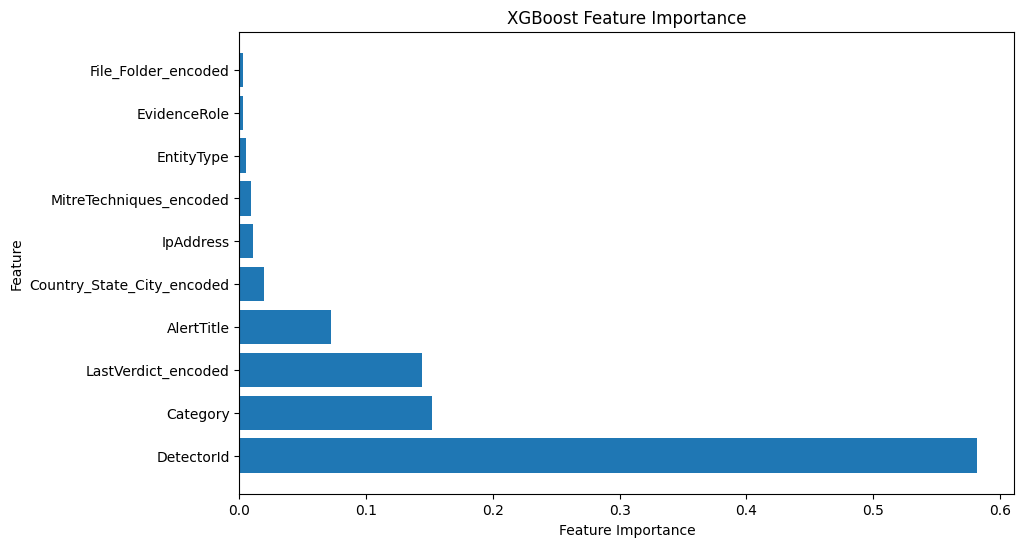

In [3]:
#XGBoost's Built-in Feature Importance:
import pandas as pd
import matplotlib.pyplot as plt

# Feature names (assumed)
feature_names = ['AlertTitle', 'Category', 'EntityType', 'EvidenceRole', 'DetectorId',
                 'IpAddress', 'Country_State_City_encoded', 'File_Folder_encoded',
                 'LastVerdict_encoded', 'MitreTechniques_encoded']

# Extract feature importance from the model
feature_importances = xgb_tuned_model.feature_importances_

# Convert to DataFrame for easy visualization
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Sort and plot
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('XGBoost Feature Importance')
plt.show()


In [6]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [9]:
import pandas as pd

# Define the path to the CSV file
file_path = '/content/drive/MyDrive/train_resampled_data.csv'

# Load the CSV file into a DataFrame
df = pd.read_csv(file_path)

# Display the first few rows of the DataFrame
print(df.head(5))


   AlertTitle  Category  EntityType  EvidenceRole  DetectorId  DeviceId  \
0   -0.310186  2.444271   -0.036682      0.095729   -0.776123       0.0   
1   -0.620309  0.278403   -0.036682      0.095729   -0.876976       0.0   
2   -0.614636  0.278403   -0.036682      0.095729   -0.742505       0.0   
3   -0.520086 -0.031007   -0.036682      0.095729    1.543503       0.0   
4    1.346326 -0.031007   -0.036682      0.095729   -0.171003       0.0   

   IpAddress  Sha256  Url  OS_Family_Version_encoded  \
0  -0.294975     0.0  0.0                        0.0   
1   0.893086     0.0  0.0                        0.0   
2   0.050630     0.0  0.0                        0.0   
3   0.212929     0.0  0.0                        0.0   
4  -0.737960     0.0  0.0                        0.0   

   Country_State_City_encoded  File_Folder_encoded  LastVerdict_encoded  \
0                    0.608337             0.071906             0.131826   
1                   -1.645637             0.071906            

In [17]:
#feature selection

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import xgboost as xgb

# Load the CSV file into a DataFrame
file_path = '/content/drive/MyDrive/train_resampled_data.csv'
df = pd.read_csv(file_path)

# Define your features and target variable
X = df[['DetectorId', 'Category', 'LastVerdict_encoded', 'AlertTitle', 'Country_State_City_encoded','IpAddress','MitreTechniques_encoded']]
y = df['IncidentGrade']  # Assuming 'IncidentGrade' is your target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the XGBoost model on the reduced feature set
xgb_model_reduced = xgb.XGBClassifier(n_estimators=300, max_depth=9, learning_rate=0.1, subsample=1.0, colsample_bytree=1.0)
xgb_model_reduced.fit(X_train, y_train)

# Make predictions
y_pred = xgb_model_reduced.predict(X_test)

# Evaluate the performance
print("Classification Report for Reduced Feature Model:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Classification Report for Reduced Feature Model:
              precision    recall  f1-score   support

           0       0.89      0.84      0.86     47374
           1       0.81      0.87      0.84     47349
           2       0.85      0.84      0.85     47652

    accuracy                           0.85    142375
   macro avg       0.85      0.85      0.85    142375
weighted avg       0.85      0.85      0.85    142375

Confusion Matrix:
[[39647  5101  2626]
 [ 1922 41138  4289]
 [ 3139  4393 40120]]


In [ ]:
#tuned xgboost gives better performance.so taking that for final evaluvation on test set

In [24]:
# Load the CSV file into a DataFrame
import pandas as pd
file_path = '/content/drive/MyDrive/test_df2.csv'
test_df = pd.read_csv(file_path, compression='gzip')

In [11]:
test_df.head(5)


,IncidentGrade,AlertTitle,Category,EntityType,EvidenceRole,DetectorId,DeviceId,IpAddress,Sha256,Url,OS_Family_Version_encoded,Country_State_City_encoded,File_Folder_encoded,LastVerdict_encoded,MitreTechniques_encoded
0,0,563,11,32,0,524,98799,360606,138268,160396,58,1712754.0,1429200.0,3,2098
1,0,563,11,32,0,524,98799,360606,138268,160396,58,1712754.0,1429200.0,3,1862
2,0,563,11,32,0,524,98799,360606,138268,160396,58,1712754.0,1429200.0,3,3833
3,0,563,11,32,0,524,98799,360606,138268,160396,58,1712754.0,1429200.0,3,1385
4,0,2,1,19,0,2,1239,360606,138268,160396,0,1712754.0,1429200.0,3,589180


In [27]:
test_df.shape

(927982, 15)

In [26]:
#Z score
import pandas as pd
from scipy import stats

# Function to cap outliers using Z-score method for a single column
def cap_outliers_by_zscore(df, column, z_thresh=3):
    """
    Caps outliers in a column in the DataFrame based on the Z-score method.

    Parameters:
    df (pd.DataFrame): The input DataFrame.
    column (str): The name of the column to check for outliers.
    z_thresh (float): The Z-score threshold to define outliers.

    Returns:
    pd.DataFrame: DataFrame with outliers capped for the specified column.
    """
    # Calculate Z-scores
    z_scores = stats.zscore(df[column])

    # Define bounds for outlier detection
    lower_bound = -z_thresh
    upper_bound = z_thresh

    # Cap values that are below lower bound and above upper bound
    df[column] = df[column].where((z_scores >= lower_bound) & (z_scores <= upper_bound), df[column].median())

    return df

# Function to apply Z-score outlier capping for multiple numerical columns
def cap_outliers_in_dataframe(df, numerical_columns, z_thresh=3):
    """
    Applies Z-score outlier capping for multiple columns in the DataFrame.

    Parameters:
    df (pd.DataFrame): The input DataFrame.
    numerical_columns (list): List of numerical columns to apply Z-score outlier capping.
    z_thresh (float): The Z-score threshold to define outliers.

    Returns:
    pd.DataFrame: DataFrame with outliers capped for the specified numerical columns.
    """
    for col in numerical_columns:
        df = cap_outliers_by_zscore(df, col, z_thresh)
    return df

# Example DataFrames (train and test)
# train_df and test_df should be predefined DataFrames containing your dataset
# Replace with the actual DataFrame loading code, e.g., pd.read_csv(...)

# List of numerical columns to cap outliers
numerical_columns = ['AlertTitle', 'DetectorId', 'DeviceId', 'IpAddress', 'Sha256', 'Url']

# Apply Z-score outlier capping to both train_df and test_df
# Example for test_df
test_df = cap_outliers_in_dataframe(test_df, numerical_columns)

# Displaying statistics of the DataFrame after outlier capping to verify
print("\nTest DataFrame after outlier capping:")
print(test_df.head(10))



Test DataFrame after outlier capping:
   IncidentGrade  AlertTitle  Category  EntityType  EvidenceRole  DetectorId  \
0              0         563        11          32             0         524   
1              0         563        11          32             0         524   
2              0         563        11          32             0         524   
3              0         563        11          32             0         524   
4              0           2         1          19             0           2   
5              0       10807        11          27             1          30   
6              0       10807        11          27             1          30   
7              0       10807        11          27             1          30   
8              0       10807        11          27             1          30   
9              1           0        10           7             1           0   

   DeviceId  IpAddress  Sha256     Url  OS_Family_Version_encoded  \
0     98799

In [28]:
test_df.duplicated().sum()

117710

In [29]:
test_df.drop_duplicates(inplace=True)

In [30]:
test_df.shape

(810272, 15)

In [76]:
test_df.columns

Index(['IncidentGrade', 'AlertTitle', 'Category', 'EntityType', 'EvidenceRole',
       'DetectorId', 'DeviceId', 'IpAddress', 'Sha256', 'Url',
       'OS_Family_Version_encoded', 'Country_State_City_encoded',
       'File_Folder_encoded', 'LastVerdict_encoded',
       'MitreTechniques_encoded'],
      dtype='object')

In [31]:
# Assuming 'IncidentGrade' is the target variable
X_test = test_df.drop(columns=['IncidentGrade'])
y_test = test_df['IncidentGrade']


In [32]:
import joblib

# Load the tuned XGBoost model
model = joblib.load('/content/tuned_decision_tree_model.pkl')


In [89]:
test_df.columns

Index(['IncidentGrade', 'AlertTitle', 'Category', 'EntityType', 'EvidenceRole',
       'DetectorId', 'IpAddress', 'Country_State_City_encoded',
       'File_Folder_encoded', 'LastVerdict_encoded',
       'MitreTechniques_encoded'],
      dtype='object')

In [33]:
# Identify the columns present in X_test but not in the training data
extra_columns = ['DeviceId', 'OS_Family_Version_encoded', 'Url', 'Sha256']

# Drop the extra columns from X_test
X_test_aligned = X_test.drop(columns=extra_columns)

# Now you can make predictions using the model
y_pred = model.predict(X_test_aligned)


In [34]:
from sklearn.metrics import f1_score, precision_score, recall_score

# Calculate macro-F1 score
macro_f1 = f1_score(y_test, y_pred, average='macro')

# Calculate precision
precision = precision_score(y_test, y_pred, average='macro')

# Calculate recall
recall = recall_score(y_test, y_pred, average='macro')

print(f'Test Data Macro-F1 Score: {macro_f1}')
print(f'Test Data Precision: {precision}')
print(f'Test Data Recall: {recall}')


Test Data Macro-F1 Score: 0.24459970232500985
Test Data Precision: 0.3007431632417468
Test Data Recall: 0.3043466613014984


In [35]:
import joblib

# Load the tuned XGBoost model
model = joblib.load('/content/xgb_tuned_model.joblib')


In [36]:
# Identify the columns present in X_test but not in the training data
extra_columns = ['DeviceId', 'OS_Family_Version_encoded', 'Url', 'Sha256']

# Drop the extra columns from X_test
X_test_aligned = X_test.drop(columns=extra_columns)

# Now you can make predictions using the model
y_pred = model.predict(X_test_aligned)


In [37]:
from sklearn.metrics import f1_score, precision_score, recall_score

# Calculate macro-F1 score
macro_f1 = f1_score(y_test, y_pred, average='macro')

# Calculate precision
precision = precision_score(y_test, y_pred, average='macro')

# Calculate recall
recall = recall_score(y_test, y_pred, average='macro')

print(f'Test Data Macro-F1 Score: {macro_f1}')
print(f'Test Data Precision: {precision}')
print(f'Test Data Recall: {recall}')


Test Data Macro-F1 Score: 0.1587670505901167
Test Data Precision: 0.26677721678569827
Test Data Recall: 0.29159569938945845
